In [82]:
import networkx as nx
import numpy as np
import pandas as pd
import random
from scipy import linalg

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

## Test Network
First we want to make a netork that is somewhat reasonable. From literature, typical verbal/semantic fluency networks have a clustering coefficient $C_\beta \approx 0.29.$ We solve for the re-wiring coefficient needed to synthesize a watts-strogatz network with that $C_\beta$ on average. 

In [3]:
from sympy import symbols, solve, Eq
K, β, C_β = symbols('K β C_β')
# K is the mean degree of a Watts-Strogatz network (given as 4)
# β is the probability of re-wiring an edge during construction

C_0 = (3*K-6)/(4*K-4)
clust_coef = Eq(C_β, C_0*(1-β)**3)

# now solve for β using params from Zemla et al.
beta = solve(clust_coef.subs({C_β:0.29, K:4}), β)[0]  
print(f'β ≈ {beta:.3f}')

β ≈ 0.166


C_β = 0.39


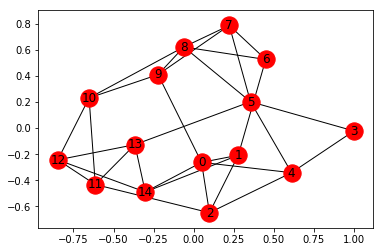

In [21]:
# let's generate a graph G
N = 15
G = nx.watts_strogatz_graph(N, 4, beta)

pos = nx.spring_layout(G)
nx.draw_networkx(G, pos=pos)
print(f'C_β = {nx.average_clustering(G):.2f}')

## Initial-visit Emitting Random Walk

In [22]:
cd ..

/home/tbsexton/Documents/Projects/structuring_knowledge


In [23]:
import lib.invite as ivt
ivt.__all__

['graph_random_walk', 'P_i', 'P_a', 'P_m']

A sample (cencored) chain, along with how many actual transitions there were (un-censored):

In [24]:
log = ivt.graph_random_walk(G)
print(log.shape,log.unique()[:11])

(64,) [ 0  2  1  4  5  3  7  9  8 10 11]


Let's make a list $m$ of individual censored walks, $a_i$

In [25]:
# Censored Random Walk
m = [ivt.graph_random_walk(G).unique()[:5] for i in range(500)]

for n,i in enumerate(m[:4]):
    print(n, ' → '.join(f'[{j :^2.0f}]' for j in i.tolist()))
print('\n'.join(i for i in 3*['.']))
print(len(m)-1, ' → '.join(f'[{j :^2.0f}]' for j in m[-1].tolist()))

0 [4 ] → [5 ] → [8 ] → [7 ] → [6 ]
1 [14] → [13] → [12] → [0 ] → [1 ]
2 [9 ] → [8 ] → [0 ] → [1 ] → [14]
3 [4 ] → [5 ] → [3 ] → [2 ] → [0 ]
.
.
.
499 [2 ] → [0 ] → [11] → [4 ] → [3 ]


## Likelihood

We generated $m$ from $G$, so let's verify that our loss function can correctly distinguish more likely networks from less likely ones: 

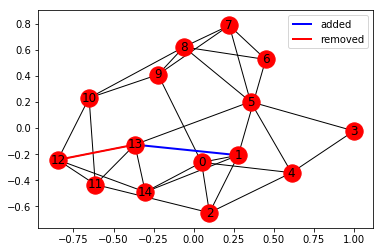

In [113]:
G2 = G.copy()
del_edge = random.choice(list(G2.edges))
non_edge = random.choice(list(nx.non_edges(G2)))
G2.add_edge(non_edge[0], non_edge[1])

nx.draw_networkx(G, pos=pos)
nx.draw_networkx_edges(G2, edgelist=[non_edge],pos=pos, 
                       edge_color='b', width=2., label='added')
nx.draw_networkx_edges(G2, edgelist=[del_edge],pos=pos,
                       edge_color='r', width=2., label='removed')

G2.remove_edge(del_edge[0], del_edge[1])
plt.legend()

### Naive
First we will directly use the transition matrix derived from G, adding a buffer to zero-probability jumps (since our modified network will potentially make observed jumps impossible)...this makes the log behave nicely. 

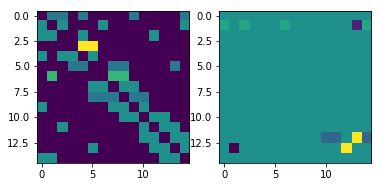

In [116]:
A = nx.to_numpy_array(G)     # adjacency matrix A

# add an epsilon to soften zeros. Turns out 7./3-4./3-1 
# is equivalent precisely to machine precision in binary
buffer = (7./3 - 4./3 - 1)*(np.ones_like(A) - np.identity(A.shape[0]))

# Right-stochastic transition matrix
A += buffer
T= A/np.sum(A, axis=1)[:, None] 

A2 = nx.to_numpy_array(G2)     # adjacency matrix A
A2 += buffer
T2 = A2/np.sum(A2, axis=1)[:, None]

f,ax = plt.subplots(ncols=2)
ax[0].imshow(T)
ax[1].imshow(T-T2)

In [119]:
from functools import partial

loss = lambda T: np.sum(np.fromiter(ivt.P_m(m, T), np.float))

loss(T), loss(T2)

(2883.4277530493755, 4156.936418799653)

Clearly working; likelihood of modified network is much lower. 

### Re-parameterized
In [Jun et al. (s2.3)](http://pages.cs.wisc.edu/~jerryzhu/pub/out-rw-flag.pdf) we see a reparameterization that looks exactly like applying a soft(arg)-max. This get's us row-stochasticity for free, and therefore keeps the minimization problem unconstrained. 

We still need to ensure self-transitions are impossible, so we set the diagonals of the transition matrix to $-\infty$

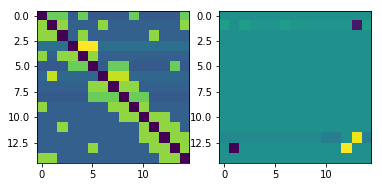

In [135]:
def softmax(x, axis=None):
    x = x - x.max(axis=axis, keepdims=True)
    y = np.exp(x)
    return y / y.sum(axis=axis, keepdims=True)

A = nx.to_numpy_array(G)     # adjacency matrix A
np.fill_diagonal(A,-np.inf)
T = softmax(A, axis=1)
# np.fill_diagonal(T,-np.inf)

A2 = nx.to_numpy_array(G2)     # adjacency matrix A
np.fill_diagonal(A2,-np.inf)
T2 = softmax(A2, axis=1)
# np.fill_diagonal(T2,-np.inf)

f,ax = plt.subplots(ncols=2)
ax[0].imshow(T)
ax[1].imshow(T-T2)

In [130]:
loss(T), loss(T2)

(4064.4067102836907, 4120.004291158129)

Still working, though much less obvious. This is ok, as we expect regularization to soften extreme shifts in the objective function (after all, we only changed two edges). 

In [131]:
%%timeit
np.sum(np.fromiter(ivt.P_m(m, T), np.float))

251 ms ± 431 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
